In [ ]:
!pip install pandas numpy scikit-learn seaborn bs4 sentence_transformers datasets transformers[torch] openai -q

In [3]:
import pandas as pd

df = pd.read_json("ml-challenge-dataset.jsonl", lines=True)

In [4]:
print("Dataframe Shape: ", df.shape)
df.head()

Dataframe Shape:  (5000, 4)


,sic,name,website_url,homepage_html
0,"[{'id': '58290', 'description': 'OTHER SOFTWAR...",AMPLIENCE (UK) LIMITED,https://amplience.com,"<!DOCTYPE html><html lang=""en""><head><link rel..."
1,"[{'id': '93290', 'description': 'OTHER AMUSEME...",GREEN MAN GAMING HOLDINGS PLC,https://www.greenmangaming.com,"﻿\n<!DOCTYPE html>\n<html lang=""en"" ng-app=""gm..."
2,"[{'id': '32990', 'description': 'OTHER MANUFAC...",THE ELECTROSPINNING COMPANY LIMITED,http://www.electrospinning.co.uk,\n<!doctype html>\n\n<!--[if lt IE 7]><html la...
3,"[{'id': '72190', 'description': 'OTHER RESEARC...",ORGANOX LIMITED,https://www.organox.com,<!doctype html>\n<!--[if lt IE 7]> <html class...
4,"[{'id': '32120', 'description': 'MANUFACTURE O...",MONICA VINADER LIMITED,https://www.monicavinader.com,"<!DOCTYPE html>\n<html lang=""en"" class=""no-js""..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sic            5000 non-null   object
 1   name           5000 non-null   object
 2   website_url    5000 non-null   object
 3   homepage_html  5000 non-null   object
dtypes: object(4)
memory usage: 156.4+ KB


In [6]:
described_df = df.describe()
described_df

,sic,name,website_url,homepage_html
count,5000,5000,5000,5000
unique,1240,5000,5000,4998
top,"[{'id': '82990', 'description': 'OTHER BUSINES...",AMPLIENCE (UK) LIMITED,https://amplience.com,"<!doctype html><html lang=""en""><head><meta htt..."
freq,250,1,1,3


<Axes: xlabel='description'>

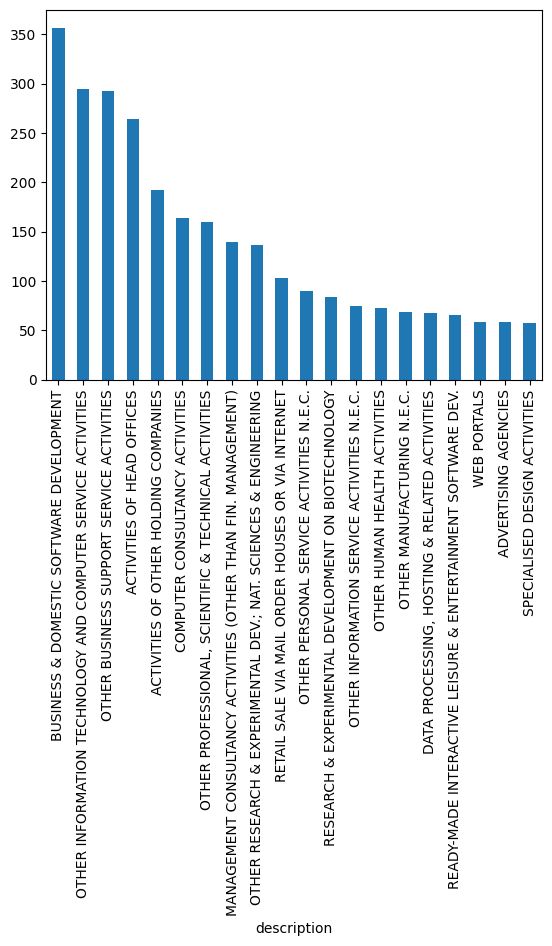

In [7]:
# Explore description feature
category_counts = df["sic"].explode()
category_counts = pd.json_normalize(category_counts)["description"].value_counts()
category_counts[:20].plot(kind="bar")

In [8]:
from bs4 import BeautifulSoup
import re


# Remove all script and style elements, replace multiple spaces with a single space
def preprocess_html(html):
    if not isinstance(html, str):
        return ""

    soup = BeautifulSoup(html, "html.parser")

    # Remove all script and style elements
    for script in soup(["script", "style"]):
        script.decompose()

    text = soup.get_text()

    # Replace multiple spaces with a single space
    text = re.sub(r"\s+", " ", text).strip()
    # Remove all digits
    text = re.sub(r"\d+", "", text)
    # Remove underscores
    text = re.sub(r"_", "", text)

    return text


df["cleaned_html"] = df["homepage_html"].apply(preprocess_html)
df["cleaned_html"].head()

0    Headless Content and Commerce. Simplified | Am...
1    ﻿ Green Man Gaming | Buy Games, Game Keys & Di...
2    The Electrospinning Company | Biomaterials | R...
3    OrganOx - OrganOx Skip to content Contact Abou...
4    Monica Vinader | Women’s Jewellery Order by pm...
Name: cleaned_html, dtype: object

In [9]:
df["cleaned_html"].apply(len).describe()

count      5000.000000
mean       4095.661800
std        5227.991512
min           0.000000
25%        1757.000000
50%        3017.000000
75%        4995.500000
max      141808.000000
Name: cleaned_html, dtype: float64

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = vectorizer.fit_transform(df["cleaned_html"])
df_tfidf = pd.DataFrame(
    tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out()
)
df["top_5_most_frequent_words"] = df_tfidf.apply(
    lambda x: x.sort_values(ascending=False).head(5).index.tolist(), axis=1
)
df["top_5_most_frequent_words"].head()

0           [headless, commerce, amplience, cms, mach]
1                     [edition, cart, add, pc, deluxe]
2    [electrospinning, biomaterials, cell, therapy,...
3      [metra, organox, transplantation, liver, donor]
4              [vermeil, ct, gold, pendant, jewellery]
Name: top_5_most_frequent_words, dtype: object

# Save clean dataframe to create descriptions

df.to_json("cleaned_ml_challenge_dataset.jsonl", lines=True, orient="records")


In [114]:
df_descriptions = pd.read_csv("descriptions.csv")
df["description"] = df_descriptions["Description"]
df["description"].head()

0    AMPLIENCE (UK) LIMITED is a leading provider o...
1    Green Man Gaming Holdings PLC is a leading dig...
2    The Electrospinning Company Limited is a pione...
3    **ORGANOX LIMITED** is at the forefront of org...
4    Monica Vinader Limited is a distinguished Brit...
Name: description, dtype: object

In [115]:
# Create sentence embeddings for the homepage_html feature
from sentence_transformers import SentenceTransformer

bert_model = SentenceTransformer("all-MiniLM-L6-v2")
df["description_bert_embedding"] = df["description"].apply(
    lambda x: bert_model.encode(x, normalize_embeddings=True)
)

In [116]:
print("Embedding length: ", len(df["description_bert_embedding"][0]))

Embedding length:  384


In [117]:
# Tool to get top N similar companies based on their description
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


def get_top_n_similar_companies(description, n=5):
    description_embedding = bert_model.encode(description, normalize_embeddings=True)

    # Stack all embeddings into a single NumPy array for fast similarity computation
    embeddings_matrix = np.vstack(df["description_bert_embedding"].values)

    # Compute cosine similarities in a single operation
    similarities = cosine_similarity([description_embedding], embeddings_matrix)[0]

    # Get the top N indices
    top_indices = np.argsort(similarities)[-n:][::-1]

    return df.iloc[top_indices]["name"]

In [118]:
stablepharma_description = """
Stablepharma Ltd is a UK-based biopharmaceutical company specializing in the development of thermostable, fridge-free vaccines. Founded in 2012 by Nick Child and Dr. Bruce Roser, the company aims to eliminate the need for the global cold chain in vaccine storage and distribution, thereby reducing vaccine wastage and improving accessibility worldwide. 
The company's proprietary StablevaX™ technology reformulates existing vaccines into a stable, pre-dosed format that can be stored at room temperature for extended periods. This innovation not only enhances vaccine stability but also reduces costs and carbon emissions associated with refrigeration. 
Stablepharma's lead product, SPVX02, is a fridge-free vaccine for the prevention of tetanus and diphtheria. In December 2024, the company submitted a Clinical Trial Application to the UK's Medicines and Healthcare products Regulatory Agency (MHRA) for SPVX02, marking a significant milestone in its development. 
In recognition of its innovative approach, Stablepharma was awarded the 2024 Fierce Life Sciences Innovation Biotech Award and was a finalist for the Pharma Industry Awards UK 2024 Biotech of the Year. 
By addressing the challenges associated with vaccine storage and distribution, Stablepharma seeks to improve global health outcomes, particularly in regions where maintaining the cold chain is difficult. 
"""

get_top_n_similar_companies(stablepharma_description)

1027      VIRUSTATIC TECHNOLOGY LTD
1528             SPYBIOTECH LIMITED
420            ADM PROTEXIN LIMITED
3145    SITRYX THERAPEUTICS LIMITED
4886       OVO BIOMANUFACTURING LTD
Name: name, dtype: object

In [119]:
hsbc_description = """
HSBC Holdings plc is a British multinational banking and financial services organization headquartered in London, England. Established in 1865 to facilitate trade between Europe and Asia, it has evolved into one of the world's largest banks, serving approximately 39 million customers across 62 countries and territories. 
The bank operates through four global businesses:
Retail Banking and Wealth Management: Providing financial services to individuals and families.
Commercial Banking: Offering services to small, medium, and large enterprises.
Global Banking and Markets: Serving corporate and institutional clients.
Global Private Banking: Catering to high-net-worth individuals.
HSBC's extensive international network positions it as a key player in facilitating global trade and investment. The bank emphasizes a commitment to sustainability, aiming to support the transition to a net-zero global economy. 
In recent developments, HSBC has announced a strategic restructuring to streamline operations and enhance efficiency. This includes combining its investment and commercial banking functions outside the UK and Hong Kong, and appointing new leadership to drive these changes.
"""

get_top_n_similar_companies(hsbc_description)

4520                ALBACO LIMITED
4897    BCB GROUP HOLDINGS LIMITED
1365     HW FISHER SERVICE LIMITED
4417            SBC MGA UK LIMITED
3247          LAPWING ADVISERS LTD
Name: name, dtype: object

In [120]:
craddys_description = """
Craddys is a leading civil and structural engineering design consultancy with over 45 years of experience. 
Founded in 1977, the firm operates from offices in Bristol, Exeter, Wakefield, and Cardiff, employing a team of more than 70 engineering professionals. 
Craddys offers a range of services, including structural engineering, civil engineering, and temporary works design, delivering economic and well-engineered solutions tailored to clients' needs. The company is committed to sustainable design practices, focusing on low-carbon and adaptable solutions to minimize environmental impact. 
"""

get_top_n_similar_companies(craddys_description)

2060                      BHA HOLDINGS LTD
3060           BRENIG CONSTRUCTION LIMITED
3948    BUILDING DESIGN (NORTHERN) LIMITED
2907           THE BRIDGFORD GROUP LIMITED
2828       CRONDALL ENERGY CONSULTANTS LTD
Name: name, dtype: object

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
import torch

model_name = "distilbert-base-uncased"

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=3, problem_type="multi_label_classification"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

df_classification = df[["description", "sic"]].copy()
df_classification["sic"] = df_classification["sic"].apply(
    lambda x: [val["id"] for val in x]
)

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df_classification["sic"])
df_classification["labels"] = list(y)
df_classification = df_classification.drop(columns=["sic"])
df_classification = df_classification.rename(columns={"description": "text"})
dataset = Dataset.from_pandas(df_classification)

def preprocess_data(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(preprocess_data, batched=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 5000/5000 [00:02<00:00, 1958.39 examples/s]


In [125]:
tokenized_dataset.save_to_disk("tokenized_dataset")

Saving the dataset (1/1 shards): 100%|██████████| 5000/5000 [00:00<00:00, 22940.20 examples/s]


In [ ]:
from transformers import TrainingArguments, Trainer

loaded_tokenized_dataset = Dataset.load_from_disk("tokenized_dataset")

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=loaded_tokenized_dataset,
    eval_dataset=loaded_tokenized_dataset,  # Normally, use a separate test set
    tokenizer=tokenizer,
)

trainer.train()

In [ ]:
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    
    with torch.no_grad():
        logits = model(**inputs).logits  # Raw model outputs

    probs = torch.sigmoid(logits)  # Convert to probabilities
    predictions = (probs > 0.5).int()  # Apply threshold

    return predictions.numpy()

# 🔹 Test Predictions
print(predict("A thrilling action-packed spy movie!"))  # Expected: Action ✅, Thriller ✅
print(predict("A lighthearted romantic comedy."))  # Expected: Comedy ✅